# 人工神經網路的簡單通用框架

使用物件導向，開發一個通用且可拓展的人工神經網路框架。

In [83]:
import numpy as np

##  二元交叉熵損失函數與梯度

In [84]:
def sigmoid(x):
    # Sigmoid 函數，常用在二元分類，將輸入值壓到 0~1 之間
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy(f, y, epsilon=1e-8):
    # 二元交叉熵損失函數
    # f: 模型預測值 (機率)
    # y: 真實標籤 (0 或 1)
    # epsilon: 避免 log(0) 用的小常數

    # 原本可能是想逐筆算 loss（被註解掉）
    # np.sum(y*np.log(f+epsilon)+ (1-y)*np.log(1-f+epsilon), axis=1)

    m = len(y)  # 資料筆數
    # 計算整體平均 loss
    return - (1./m) * np.sum(
        np.multiply(y, np.log(f + epsilon)) +
        np.multiply((1 - y), np.log(1 - f + epsilon))
    )

def binary_cross_entropy_grad(out, y, sigmoid_out=True, epsilon=1e-8):
    # 計算 binary cross entropy 對輸出值的梯度
    # out: 模型輸出
    # y: 真實標籤
    # sigmoid_out: 表示 out 是否已經過 sigmoid

    if sigmoid_out:
        f = out  # 如果已經是 sigmoid 輸出，直接使用
        grad = ((f - y) / (f * (1 - f) + epsilon)) / (len(y))
        # f = np.clip(f, eps, 1 - eps) # 建議寫法
        # grad = ((f - y) / (f * (1 - f))) / (len(y))
    else:
        f = sigmoid(out)  # 如果 out 是 z，先做 sigmoid
        grad = (f - y) / (len(y))

def binary_cross_entropy_loss_grad(out, y, sigmoid_out=True, epsilon=1e-8):
    # 同時計算 loss 與 gradient
    # 常用在訓練時一次回傳兩個結果

    if sigmoid_out:
        f = out  # 已經是 sigmoid 結果
        grad = ((f - y) / (f * (1 - f) + epsilon)) / (len(y))
        # f = np.clip(f, eps, 1 - eps) # 建議寫法
        # grad = ((f - y) / (f * (1 - f))) / (len(y))
    else:
        f = sigmoid(out)  # out 是尚未經過 sigmoid 的值
        grad = (f - y) / (len(y))

    # 計算 binary cross entropy loss
    loss = binary_cross_entropy(f, y, epsilon)

    return loss, grad

## softmax交叉熵損失函數與梯度

In [85]:
def softmax(Z):
    # 對輸入的 Z 做 softmax，先減掉最大值避免數值爆掉
    A = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    # 將指數結果做正規化，讓每一列加起來等於 1
    return A / np.sum(A, axis=-1, keepdims=True)

def softmax_cross_entropy(Z, y, onehot=False):
    # 樣本的總數（有幾筆資料）
    m = len(Z)

    # 先把模型輸出 Z 丟進 softmax，算出每一類的機率
    F = softmax(Z)

    if onehot:
        # 如果 y 是 one-hot 編碼
        # 直接用 cross entropy 的公式算 loss
        loss = -np.sum(y * np.log(F)) / m
    else:
        # 如果 y 是類別的 index（例如 0、1、2）
        # 把 y 攤平成一維（但這行實際上不會影響後面）
        y.flatten()

        # 取出每筆資料「正確類別」對應的機率，再取 log
        log_Fy = -np.log(F[range(m), y])

        # 把所有樣本的 loss 加起來，再取平均
        loss = np.sum(log_Fy) / m

    return loss

def cross_entropy_grad(Z, Y, onehot=False, softmax_out=False):
    # 判斷輸入的 Z 是不是已經是 softmax 的輸出
    if softmax_out:
        F = Z
    else:
        # 如果不是，就先做一次 softmax
        F = softmax(Z)

    if onehot:
        # 如果 Y 是 one-hot 編碼，直接用 F - Y
        grad = (F - Y) / len(Z)
    else:
        # 如果 Y 是類別索引（例如 [0, 2, 1]）
        m = len(Y)          # 樣本數
        grad = F.copy()       # 複製一份避免動到原本的 F
        # 對正確類別的位置減 1
        grad[np.arange(m), Y] -= 1
        # 對 batch size 做平均
        grad /= m

        # 以下是另一種寫法，這裡先註解起來
        # I_i = np.zeros_like(Z)
        # I_i[np.arange(len(Z)),Y] = 1
        # return (F - I_i) /len(Z)  #Z.shape[0]

    # 回傳對 Z 的梯度
    return grad

# def cross_entropy_grad_loss(F, y, softmax_out=False, onehot=False):
#     # 判斷輸入的 F 是否已經經過 Softmax 處理
#     if softmax_out:
#         # 如果已經是機率分布了，直接丟進去算 Loss
#         loss = softmax_cross_entropy(F, y, onehot)
#         # 註解掉的這行可能是想區分一般的 Cross Entropy 與 Softmax 版
#         # loss = cross_entropy_loss(F, y, onehot)
#     else:
#         # 如果 F 還是 Logits（原始輸出），則執行含 Softmax 的 Cross Entropy 計算
#         loss = softmax_cross_entropy(F, y, onehot)

#     # 計算梯度（Grad），同樣會根據 softmax_out 決定內部是否要補做 Softmax
#     grad = cross_entropy_grad(F, y, onehot, softmax_out)

#     # 同時回傳損失值與梯度，方便後向傳播使用
#     return loss, grad

def cross_entropy_grad_loss(Z, y, softmax_out=False, onehot=False):
    """
    優化後的函式：共用 Softmax 運算結果，同時回傳 Loss 與 Gradient。
    """
    # 1. 決定機率分布 F (Softmax 的結果)
    if softmax_out:
        # 如果已經是 Softmax 輸出，直接共用
        F = Z
    else:
        # 如果是 Logits，算一次 Softmax 就好，後面大家都用這份 F
        F = softmax(Z)

    # 2. 計算 Loss
    # 注意：這裡我們傳入已經算好的 F，並告訴後面的函式 softmax_out=True
    # (假設你原有的 softmax_cross_entropy 有支援這個判斷，或是我們直接在這裡算)
    m = len(y)
    if onehot:
        loss = -np.sum(y * np.log(F + 1e-12)) / m
    else:
        # 這裡示範直接計算，減少函式呼叫的開銷
        loss = -np.sum(np.log(F[np.arange(m), y] + 1e-12)) / m

    # 3. 計算梯度 (Gradient)
    # 直接利用剛剛算好的 F 進行計算，效能最優
    grad = F.copy()
    if onehot:
        grad = (grad - y) / m
    else:
        grad[np.arange(m), y] -= 1
        grad /= m

    return loss, grad

## 平均平方誤差損失函數與梯度

In [86]:
def mse_loss_grad(f, y):
    m = len(f)
    # 計算資料筆數（樣本數）

    loss = (1./m) * np.sum((f - y) ** 2)
    # 計算 MSE（均方誤差），用來衡量預測值跟實際值的差距

    grad = (2./m) * (f - y)
    # 計算 MSE 對預測值 f 的梯度，常用在梯度下降

    return loss, grad
    # 回傳 loss 值以及對應的梯度

## 其他函數

In [87]:
def dRelu(x):
    # ReLU 的微分：x > 0 回傳 1，否則回傳 0
    return 1 * (x > 0)

def max_abs(s):
    # 計算一組矩陣或向量中，所有元素的最大絕對值
    max_value = 0
    for x in s:
        max_value_ = np.max(np.abs(x))  # 取單一矩陣的最大絕對值
        if(max_value_ > max_value):
            max_value = max_value_
    return max_value

# 產生一個非線性可分（Non-linearly separable）的「旋渦狀」資料集
def gen_spiral_dataset(N=100, D=2, K=3):
    # 初始化特徵矩陣 X，形狀為 (樣本總數, 維度)，這裡預設產生 300 筆 2 維資料
    X = np.zeros((N*K, D))  # 建立資料矩陣，每一列代表一筆資料

    # 初始化標籤陣列 y，記錄每筆資料屬於哪一個類別（0, 1, 2）
    y = np.zeros(N*K, dtype='uint8')  # 建立標籤陣列，用來存每筆資料的類別

    for j in range(K):  # 依序產生每一個類別 (Class) 的資料
        # 計算目前類別在矩陣中對應的索引範圍 (Index range)
        ix = range(N*j, N*(j+1))

        # 產生半徑 r，從 0 到 1 均勻分布，代表點從原點往外擴散
        r = np.linspace(0.0, 1, N)  # 半徑，從中心往外均勻增加

        # 產生角度 t，隨類別不同有不同的起始角度，並加入高斯雜訊 (Noise) 讓資料不會太死板
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2  # 角度，加上一點雜訊讓資料比較分散

        # 利用極座標轉直角座標 (r*sin(t), r*cos(t))，並用 np.c_ 進行欄位合併
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]  # 轉成平面座標，形成螺旋狀

        # 填入對應的類別編號
        y[ix] = j  # 設定對應的類別標籤

    return X, y  # 回傳產生的特徵矩陣 X 與目標標籤 y

## 神經網路層子類別

In [88]:
# 神經網路層類別
class Layer:
    def __init__(self):
        pass

    def forward(self, x):
        # 前向傳播，實際運算由子類別實作
        raise NotImplementedError

    def backward(self, grad):
        # 反向傳播，實際梯度計算由子類別實作
        raise NotImplementedError


class Dense(Layer):
    def __init__(self, input_dim, out_dim, activation=None):
        super().__init__()
        # 初始化權重矩陣，數值縮小避免一開始數值太大
        self.W = np.random.randn(input_dim, out_dim) * 0.01
        # 初始化 bias，全部設為 0
        self.b = np.zeros((1, out_dim))

        # 紀錄使用的啟動函數類型
        self.activation = activation
        # 儲存前向傳播後的輸出
        self.A = None

    def forward(self, x):
        # 前向傳播：計算線性組合 f(x) = xW + b
        self.x = x  # 保留輸入，供反向傳播使用
        Z = np.matmul(x, self.W) + self.b
        # 套用啟動函數
        self.A = self.g(Z)
        return self.A

    def backward(self, dA_out):
        # 反向傳播：計算梯度
        A_in = self.x  # 前一層的輸入
        # 計算 dZ
        dZ = self.dZ_(dA_out)

        # 計算權重與 bias 的梯度
        self.dW = np.dot(A_in.T, dZ)
        self.db = np.sum(dZ, axis=0, keepdims=True)
        # 計算傳回前一層的梯度
        dA_in = np.dot(dZ, np.transpose(self.W))
        return dA_in

    def g(self, z):
        # 啟動函數
        if self.activation == 'relu':
            # ReLU
            return np.maximum(0, z)
        elif self.activation == 'Sigmoid':
            # Sigmoid
            return 1 / (1 + np.exp(-z))
        # elif self.activation == 'Softmax':
        #     A = np.exp(z - np.max(z, axis=-1, keepdims=True))
        #     return A / np.sum(A, axis=-1, keepdims=True)
        else:
            # 沒有指定啟動函數就直接輸出
            return z

    def dZ_(self, dA_out):
        # 計算啟動函數對 Z 的微分
        if self.activation == 'relu':
            # ReLU 的梯度
            grad_g_z = 1. * (self.A > 0)
            return np.multiply(dA_out, grad_g_z)
        elif self.activation == 'Sigmoid':
            # Sigmoid 的梯度
            grad_g_z = self.A * (1 - self.A)
            return np.multiply(dA_out, grad_g_z)
        else:
            # 無啟動函數時，梯度直接往前傳
            return dA_out

## 測試：人工神經網路的向前函式

In [89]:
import numpy as np

# 設定隨機種子，確保每次產生的隨機數結果都一樣，方便除錯與重現結果
np.random.seed(1)

# 產生一個隨機矩陣
# 形狀為 (3, 48)，代表 3 筆資料，每筆資料有 48 個特徵
x = np.random.randn(3, 48)  # 3 個樣本，每個樣本有 48 維特徵

# 建立一個全連接層 (Dense Layer)
# 輸入維度為 48，輸出維度為 10，啟用函數設定為 'none'
dense = Dense(48, 10, 'none')

# 將輸入資料丟進 Dense 層做前向傳播
o = dense.forward(x)

# 輸出結果的形狀
print(o.shape)

# 輸出實際計算結果
print(o)

(3, 10)
[[-0.03953509 -0.00214997  0.00743433 -0.16926214 -0.05162853  0.06734225
  -0.00221485 -0.11710758 -0.07046456  0.02609659]
 [ 0.00848392  0.08259757 -0.09858177  0.0374092  -0.08303008  0.04151241
  -0.01407859 -0.02415486  0.04236149  0.0648261 ]
 [-0.13877363 -0.04122276 -0.00984716 -0.03461381  0.11513754  0.1043094
   0.00170353 -0.00449278 -0.0057236  -0.01403174]]


In [90]:
def numerical_gradient_from_df(f, p, df, h=1e-5):
  # 建立一個與 p 形狀相同、內容全為 0 的陣列，用來存每個參數的梯度
  grad = np.zeros_like(p)

  # 使用 nditer 逐一走訪 p 中的每一個元素（支援多維陣列）
  it = np.nditer(p, flags=['multi_index'], op_flags=['readwrite'])

  # 只要 iterator 還沒跑完就持續計算
  while not it.finished:
    # 取得目前走訪到的索引位置
    idx = it.multi_index

    # 先把原本的參數值存起來
    oldval = p[idx]

    # 將該參數往正方向微調一點
    p[idx] = oldval + h
    pos = f()       # 在參數被改動後重新呼叫 f()，取得正方向的輸出結果

    # 將該參數往負方向微調一點
    p[idx] = oldval - h
    neg = f()       # 在參數被改動後重新呼叫 f()，取得負方向的輸出結果

    # 將參數值還原成原本的狀態，避免影響下一次計算
    p[idx] = oldval

    # 使用中央差分法計算梯度，並與上游傳下來的 df 做加權
    grad[idx] = np.sum((pos - neg) * df) / (2 * h)

    # 另一種寫法（使用內積），目前被註解掉
    # grad[idx] = np.dot((pos - neg), df) / (2 * h)

    # 移動到下一個參數位置
    it.iternext()

  # 回傳整個參數 p 的數值梯度
  return grad

# 通用數值梯度函式
def numerical_gradient(f, params, eps=1e-6):
    numerical_grads = []  # 用來存每一個參數對應的梯度

    for x in params:
        # x 可能是多維陣列，這裡會針對 x 裡面的每一個元素計算數值梯度
        grad = np.zeros(x.shape)  # 建立一個跟 x 形狀一樣的陣列來存梯度

        # 使用 nditer 逐一走訪 x 裡面的每個元素
        it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

        while not it.finished:
            idx = it.multi_index   # 目前元素的索引位置

            old_value = x[idx]     # 先把原本的值存起來

            x[idx] = old_value + eps  # 對目前的值加上一個很小的 eps
            fx = f()                  # 計算 f(x + eps) 的結果

            x[idx] = old_value - eps  # 對目前的值減去一個很小的 eps
            fx_ = f()                 # 計算 f(x - eps) 的結果

            # 使用中央差分法計算數值梯度
            grad[idx] = (fx - fx_) / (2 * eps)

            x[idx] = old_value        # 記得把參數值還原，避免影響後續計算
            it.iternext()             # 移動到下一個元素

        numerical_grads.append(grad)  # 將目前參數的梯度存起來

    return numerical_grads            # 回傳所有參數的梯度

# def f():
#     return compute_loss_reg(forward_propagation, softmax_cross_entropy_reg, X, y, parameters)

In [91]:
import numpy as np

# 隨機產生一個形狀為 (3, 10) 的矩陣，模擬從上一層（後方層）傳回來的梯度 (df / Loss 對輸出值的偏微分)
df = np.random.randn(3, 10)

# 定義計算誤差的函式，取代原有的 lambda
def get_max_abs_error(grad_analyt, grad_num):
    """
    計算解析解梯度與數值解梯度之間的最大絕對誤差
    """
    return np.max(np.abs(grad_analyt - grad_num))

# 定義 Forward 封裝函式，供數值微分工具調用
def forward_pass():
    return dense.forward(x)

# 1. 執行反向傳播計算梯度 (解析解)
dx = dense.backward(df)

# 2. 利用數值微分估算梯度 (將 forward_pass 作為參數傳入)
dx_num = numerical_gradient_from_df(forward_pass, x, df)

# 3. 計算誤差
diff = get_max_abs_error(dx, dx_num)

if diff < 1e-10:
    print("輸入資料 (x) 的梯度檢驗通過：差距很小！")
print(f"x 梯度誤差: {diff}")

# --- 針對權重 (W) 的部分 ---

# 同樣利用數值微分，計算權重矩陣 (dense.W) 的數值梯度
# 注意：這裡 forward_pass 依然可以使用，因為它內部調用的 x 與 dense 狀態是共用的
dW_num = numerical_gradient_from_df(forward_pass, dense.W, df)

diff = get_max_abs_error(dense.dW, dW_num)

if diff < 1e-10:
    print("權重 (W) 的梯度檢驗通過：差距很小！")
print(f"W 梯度誤差: {diff}")

輸入資料 (x) 的梯度檢驗通過：差距很小！
x 梯度誤差: 2.1851062625977136e-12
權重 (W) 的梯度檢驗通過：差距很小！
W 梯度誤差: 2.2715163083830703e-12


## 人工神經網路類別

In [92]:
class NeuralNetwork:
    def __init__(self):
        self._layers = []   # 用來存放所有網路層的清單

    def add_layer(self, layer):
        self._layers.append(layer)  # 將新的 layer 加到網路中

    def forward(self, X):
        self.X = X              # 記錄輸入資料
        for layer in self._layers:
            X = layer.forward(X)  # 依序經過每一層做 forward 計算
        return X                 # 回傳最後輸出

    def predict(self, X):
        p = self.forward(X)     # 先做 forward 得到預測結果

        if p.ndim == 1:         # 如果是單一樣本
            return np.argmax(p)  # 回傳機率最大的類別

        # 多筆樣本的情況
        return np.argmax(p, axis=1)


    def backward(self, loss_grad, reg=0.):
        # 反向傳播，從最後一層往前算梯度
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]
            loss_grad = layer.backward(loss_grad)

        # 將正則化項加入權重梯度
        for i in range(len(self._layers)):
            self._layers[i].dW += 2 * reg * self._layers[i].W

    def reg_loss(self, reg):
        loss = 0
        # 計算所有層的 L2 正則化損失
        for i in range(len(self._layers)):
            loss += reg * np.sum(self._layers[i].W * self._layers[i].W)
        return loss

    def update_parameters(self, learning_rate):
        # 依照學習率更新每一層的權重與偏置
        for i in range(len(self._layers)):
            self._layers[i].W += -learning_rate * self._layers[i].dW
            self._layers[i].b += -learning_rate * self._layers[i].db

    def parameters(self):
        params = []
        # 收集所有層的參數（權重與偏置）
        for i in range(len(self._layers)):
            params.append(self._layers[i].W)
            params.append(self._layers[i].b)
        return params

    def grads(self):
        grads = []
        # 收集所有層的梯度
        for i in range(len(self._layers)):
            grads.append(self._layers[i].dW)
            grads.append(self._layers[i].db)
        return grads

In [93]:
# 建立一個神經網路物件
nn = NeuralNetwork()

# 新增第一層全連接層：輸入 2 維，輸出 100 維，使用 ReLU 當啟動函數
nn.add_layer(Dense(2, 100, 'relu'))

# 新增第二層全連接層：輸入 100 維，輸出 3 維，使用 softmax 做分類
nn.add_layer(Dense(100, 3, 'softmax'))

# 隨機產生一組輸入資料（2 筆資料，每筆 2 維）
X_temp = np.random.randn(2,2)

# 隨機產生對應的標籤（類別數為 3）
y_temp = np.random.randint(3, size=2)

# 將資料丟進神經網路做前向傳播
F = nn.forward(X_temp)

# 計算 softmax cross entropy 的 loss
loss = softmax_cross_entropy(F,y_temp)

# 計算 cross entropy 對輸出的梯度
loss_grad =  cross_entropy_grad(F,y_temp)

# 印出 loss 以及梯度的平均值，方便快速檢查結果
print(loss, np.mean(loss_grad))

1.098695480580774 -9.25185853854297e-18


In [94]:
# 1. 執行後向傳播 (Backward Pass)
# 根據損失函數對輸出的梯度 (loss_grad) 來計算模型中所有參數的梯度
nn.backward(loss_grad)

# 從網路物件中抓出剛剛算好的所有參數梯度 (解析解)
grads = nn.grads()

# 2. 定義一個用來做數值微分的閉包 (Closure)
def loss_fun():
    # 這裡會用到暫存的資料 X_temp
    F = nn.forward(X_temp)
    # 回傳當下的損失值 (Loss)
    return softmax_cross_entropy(F, y_temp)

# 3. 取得模型內所有的參數 (Parameters)，包含各層的 W 和 b
params = nn.parameters()

# 利用數值方法 (如中心差分) 算出每個參數的數值梯度 (Numerical Gradient)
# 1e-6 是微小的偏移量 epsilon
numerical_grads = numerical_gradient(loss_fun, params, 1e-6)

# 4. 檢查兩者的形狀是否一致 (Shape Check)
for i in range(len(params)):
    # 確保數值梯度的矩陣形狀跟解析梯度完全一樣
    print(numerical_grads[i].shape, grads[i].shape)

# 5. 定義誤差計算函式
def diff_error(x, y):
    # 計算單一參數矩陣的最大絕對誤差
    return np.max(np.abs(x - y))

def diff_errors(xs, ys):
    errors = []
    # 遍歷所有層的參數梯度
    for i in range(len(xs)):
        errors.append(diff_error(xs[i], ys[i]))
    # 回傳所有參數中「最大」的那一個誤差值
    return np.max(errors)

# 6. 最後輸出總體誤差
# 如果這個值小於 1e-7，通常代表你的 Backprop 寫得非常完美！
diff_errors(numerical_grads, grads)

(2, 100) (2, 100)
(1, 100) (1, 100)
(100, 3) (100, 3)
(1, 3) (1, 3)


np.float64(2.3017241064515748e-10)

In [95]:
def train(nn, X, y, loss_function, epochs=10000, learning_rate=1e-0, reg=1e-3, print_n=10):
    # 開始執行指定次數的訓練循環 (Epochs)
    for epoch in range(epochs):
        # 1. 前向傳播 (Forward Pass)：將資料丟進網路，得到預測結果 f (Logits)
        f = nn.forward(X)

        # 2. 計算損失與梯度：使用傳入的 loss_function 算出 Loss 以及對應的梯度 loss_grad
        loss, loss_grad = loss_function(f, y)

        # 3. 加入正規化損失 (Regularization Loss)：防止權重過大導致過擬合 (Overfitting)
        loss += nn.reg_loss(reg)

        # 4. 後向傳播 (Backward Pass)：將梯度傳回網路各層，計算權重與偏置的梯度
        nn.backward(loss_grad, reg)

        # 5. 更新參數 (Parameter Update)：根據算出的梯度與學習率，調整網路參數
        nn.update_parameters(learning_rate)

        # 6. 定期列印 Log：每隔 print_n 次就印出目前的損失值，追蹤訓練進度
        if epoch % print_n == 0:
            print("iteration %d: loss %f" % (epoch, loss))

## 模型訓練範例

### 範例漩渦資料

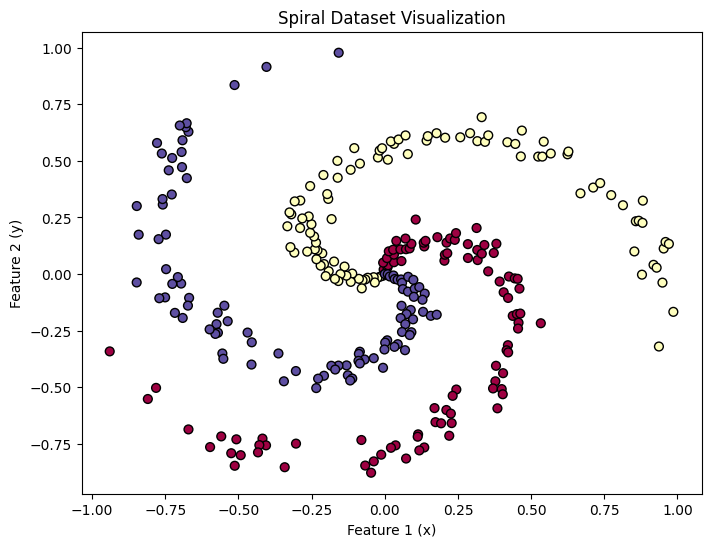

In [96]:
import matplotlib.pyplot as plt

# 1. 產生螺旋資料
X, y = gen_spiral_dataset(N=100, D=2, K=3)

# 2. 建立畫布
plt.figure(figsize=(8, 6))

# 3. 畫出散佈圖 (Scatter Plot)
# X[:, 0] 是橫軸 (x 座標), X[:, 1] 是縱軸 (y 座標)
# c=y 代表根據類別自動上色, s=40 是點的大小, edgecolor='k' 是加上黑色邊框比較好辨識
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolor='k')

# 4. 加上標題與標籤
plt.title("Spiral Dataset Visualization")
plt.xlabel("Feature 1 (x)")
plt.ylabel("Feature 2 (y)")

# 5. 顯示圖表
plt.show()

### 實際的訓練腳本程式

In [99]:
# 設定隨機編號（Seed），確保每次執行結果都一樣，方便除錯（Debug）
np.random.seed(89)

# 產生螺旋狀的測試資料集 X（特徵）與 y（標籤）
X, y = gen_spiral_dataset(N=100, D=2, K=3)

# 設定訓練參數
epochs = 10000            # 總共要跑多少個循環（Epochs）
learning_rate = 1e-0      # 學習率（步長），這裡設定為 1.0
reg = 1e-4                # 正規化係數（Regularization Strength），用來防止過擬合（Overfitting）
print_n = epochs // 10    # 設定每跑 10% 的進度就印一次 Log

# # 建立一個神經網路物件
# ann = NeuralNetwork()

# # 新增第一層全連接層：輸入 2 維，輸出 100 維，使用 ReLU 當啟動函數
# ann.add_layer(Dense(2, 100, 'relu'))

# # 新增第二層全連接層：輸入 100 維，輸出 3 維，使用 softmax 做分類
# ann.add_layer(Dense(100, 3))

# 開始訓練模型
# 傳入模型物件 nn、資料、損失與梯度的整合函式，以及相關超參數
train(nn, X, y, cross_entropy_grad_loss, epochs, learning_rate, reg, print_n)

# 訓練完成後，計算模型在訓練集上的準確度（Accuracy）
# nn.predict(X) 會回傳預測類別，並與真實標籤 y 比較取平均值
print(np.mean(nn.predict(X) == y))

iteration 0: loss 1.098749
iteration 1000: loss 0.199245
iteration 2000: loss 0.129508
iteration 3000: loss 0.116411
iteration 4000: loss 0.110031
iteration 5000: loss 0.105776
iteration 6000: loss 0.103647
iteration 7000: loss 0.102508
iteration 8000: loss 0.101521
iteration 9000: loss 0.100991
0.9933333333333333
